In [2]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import kstest, norm, geom

def initialize_parameters_adaptive(observations, n_states, window_size):
    
    observations_array = np.array(observations)
    initial_data = observations_array[:window_size]

   
    quantiles = np.quantile(initial_data, [0.5])  
    
    # Initialize the means and variances using quantiles
    means = []
    variances = []
    for q in quantiles:
        means.append(np.mean(initial_data[initial_data <= q]))
        means.append(np.mean(initial_data[initial_data > q]))
        variances.append(np.var(initial_data[initial_data <= q]))
        variances.append(np.var(initial_data[initial_data > q]))

    means = np.array(means)
    variances = np.array(variances)

    # Initialize start probabilities based on the frequency of being below or above the median
    start_prob = np.array([np.mean(initial_data <= quantiles[0]), np.mean(initial_data > quantiles[0])])
    
    # Initialize transition probabilities with a bias towards staying in the same state
    trans_prob = np.full((n_states, n_states), (1 - 0.99) / (n_states - 1))
    np.fill_diagonal(trans_prob, 0.99)
    trans_prob = np.clip(trans_prob, 1e-6, 1 - 1e-6)
    
    return {
        'means': means,
        'variances': variances,
        'start_prob': start_prob,
        'trans_prob': trans_prob
    }


def log_gaussian_pdf(x, mean, var):
    if np.any(var <= 0):
        raise ValueError("All variances must be greater than zero.")
    coefficient = -0.5 * np.log(2 * np.pi * var)
    exponential = -0.5 * ((x - mean)**2 / var)
    return coefficient + exponential

def log_forward(obs_seq, start_prob, trans_prob, means, variances):
    N = len(obs_seq)
    M = start_prob.shape[0]
    fwd = np.full((N, M), -np.inf)
    log_start_prob = np.log(start_prob)
    log_trans_prob = np.log(trans_prob)
    
    fwd[0, :] = log_start_prob + log_gaussian_pdf(obs_seq[0], means, variances)

    for t in range(1, N):
        for j in range(M):
            for i in range(M):
                fwd[t, j] = np.logaddexp(fwd[t, j], fwd[t-1, i] + log_trans_prob[i, j] + log_gaussian_pdf(obs_seq[t], means[j], variances[j]))

    return fwd

def log_backward(obs_seq, trans_prob, means, variances):
    N = len(obs_seq)
    M = trans_prob.shape[0]
    bwd = np.full((N, M), -np.inf)
    log_trans_prob = np.log(trans_prob)
    
    bwd[N-1, :] = 0  # log(1)

    for t in range(N-2, -1, -1):
        for i in range(M):
            for j in range(M):
                bwd[t, i] = np.logaddexp(bwd[t, i], log_trans_prob[i, j] + log_gaussian_pdf(obs_seq[t+1], means[j], variances[j]) + bwd[t+1, j])

    return bwd

def compute_gammas(log_fwd, log_bwd):
    max_log_fwd = np.max(log_fwd, axis=1, keepdims=True)
    max_log_bwd = np.max(log_bwd, axis=1, keepdims=True)
    linear_fwd = np.exp(log_fwd - max_log_fwd)
    linear_bwd = np.exp(log_bwd - max_log_bwd)
    gammas = (linear_fwd * linear_bwd) / np.sum(linear_fwd * linear_bwd, axis=1, keepdims=True)
    return gammas

def compute_score_function(obs_seq, params, log_fwd, log_bwd):
    N = len(obs_seq)
    M = len(params['means'])
    
    # Compute the gradient of log-likelihood (score function) w.r.t. parameters
    score_means = np.zeros(M)
    score_vars = np.zeros(M)
    
    gammas = compute_gammas(log_fwd, log_bwd)  # Ensure that gammas are computed here or passed to the function

    for state in range(M):
        for t in range(N):
            # Expected sufficient statistics for mean
            score_means[state] += gammas[t, state] * (obs_seq[t] - params['means'][state])
            # Expected sufficient statistics for variance
            score_vars[state] += gammas[t, state] * (obs_seq[t] - params['means'][state])**2 - params['variances'][state]
    
    # Combine scores for all parameters into a single array
    score = np.concatenate((score_means, score_vars))
    return score


def compute_fisher_information(gammas, params):
    n_states = len(params['means'])
    n_parameters = 2 * n_states  # means and variances for each state
    fisher_info = np.zeros((n_parameters, n_parameters))
    
    # Calculate the Fisher information matrix entries
    for state in range(n_states):
        # Fisher information for mean
        fisher_info[state, state] = np.sum(gammas[:, state] / params['variances'][state])
        # Fisher information for variance
        fisher_info[n_states + state, n_states + state] = np.sum(gammas[:, state] / (2 * params['variances'][state]**2))
    
    return fisher_info

def update_parameters_with_fisher_scaling(params, score, fisher_info, A):
    # Calculate the inverse Fisher information matrix
    fisher_info_inv = np.linalg.inv(fisher_info + np.eye(len(score)) * 1e-4) 

    # Scale the score by the inverse Fisher information
    scaled_score = fisher_info_inv @ score

    # Update the parameters using the scaled score
    params['means'] += A * scaled_score[:len(params['means'])]
    params['variances'] += A * scaled_score[len(params['means']):]

    # Ensuring variances remain positive
    params['variances'] = np.maximum(params['variances'], 1e-6)

    return params

def update_transition_matrix(gammas, trans_prob, A):
    # Calculate updated transition probabilities based on gammas
    n_states = len(trans_prob)
    updated_trans_matrix = np.full((n_states, n_states), 0.001)  # Initialize with 0.01
    np.fill_diagonal(updated_trans_matrix, 0.999) 
    
    for i in range(n_states):
        for j in range(n_states):
            # Accumulate transition counts from state i to state j
            transition_counts = np.sum(gammas[:-1, i] * gammas[1:, j])
            # Smooth the transitions with the existing values
            updated_trans_matrix[i, j] = A * transition_counts + (1 - A) * trans_prob[i, j]
    
    # Normalize the rows of the transition matrix to sum to 1
    updated_trans_matrix /= np.sum(updated_trans_matrix, axis=1, keepdims=True)
    return updated_trans_matrix

def forecast_state_probabilities(alpha_T, T_matrix, k):
  
    alpha_Tk = np.linalg.matrix_power(T_matrix, k) @ alpha_T
    return alpha_Tk

def forecast_first_moments(mu_i, alpha_Tk):
 
    mu = np.sum(mu_i * alpha_Tk)
    return mu

def forecast_second_moments(sigma_i_squared, mu_i, alpha_Tk):

    # Ensure inputs are arrays
    sigma_i_squared = np.asarray(sigma_i_squared)
    mu_i = np.asarray(mu_i)
    alpha_Tk = np.asarray(alpha_Tk)

    # Check if inputs are one-dimensional
    if not (sigma_i_squared.ndim == mu_i.ndim == alpha_Tk.ndim == 1):
        raise ValueError("All inputs must be one-dimensional arrays.")

    # Calculate the second moment for each state
    second_moment = (sigma_i_squared + mu_i**2) * alpha_Tk
    total_second_moment = np.sum(second_moment)

    # Calculate the variance
    total_first_moment_squared = np.sum(mu_i * alpha_Tk)**2
    variance = total_second_moment - total_first_moment_squared

    return variance

def forecast_returns(mu, sigma_squared):
  
    expected_returns = np.exp(mu + sigma_squared / 2) - 1
    variance_returns = (np.exp(sigma_squared) - 1) * np.exp(2 * mu + sigma_squared)
    return expected_returns, variance_returns

def optimization(h0, invested, forecasted_means, forecasted_variances, p_vec, com_rate, risk_para, trade_para, K):
    

    # Initialize portfolio balances
    asset_bal = h0 * invested  # Amount invested in the asset
    cash_bal = h0 - asset_bal  # Amount held as cash

    # Iterate through each time step (K)
    for i in range(K):
        # Calculate the change in investment based on the new allocation p_vec[i]
        if i == 0:
            amount_chg = h0 * (p_vec[i] - invested)
        else:
            amount_chg = (asset_bal + cash_bal) * (p_vec[i] - p_vec[i-1])
        
        # Update invested amount by returns, and cash balance by the change and commission
        asset_bal = (asset_bal + amount_chg) * (1 + forecasted_means[i])
        cash_bal -= (amount_chg + abs(amount_chg) * com_rate)
        
        # Compute portfolio value and adjust for risk and trading aversion
        V = asset_bal + cash_bal
        risk_aversion_cost = risk_para * (asset_bal**2 * forecasted_variances[i]) / V
        trading_aversion_cost = trade_para * abs(amount_chg) / V
        V -= (risk_aversion_cost + trading_aversion_cost)

        # Update the asset and cash balances for the next time step
        asset_bal = V * p_vec[i]
        cash_bal = V - asset_bal

    return V

def optimize_portfolio_allocation(h0, invested, forecasted_means, forecasted_variances, com_rate, risk_para, trade_para, K, max_change_per_step=0.05):
    # Constraint to limit change in allocation between steps
    def allocation_change_constraint(p_vec):
        # The allocation change must be greater than or equal to -max_change_per_step and less than or equal to max_change_per_step
        return np.all(-max_change_per_step <= np.diff(p_vec, prepend=invested)) and np.all(np.diff(p_vec, prepend=invested) <= max_change_per_step)

    # Define the objective function to be minimized (negative of terminal portfolio value)
    def objective_function(p_vec):
        # Check if p_vec has any infeasible allocation, return a large negative number if infeasible
        if not allocation_change_constraint(p_vec):
            return -np.inf
        return -optimization(h0, invested, forecasted_means, forecasted_variances, p_vec, com_rate, risk_para, trade_para, K)

    # Set up initial guess and bounds
    initial_guess = np.full(K, invested)  # Start with the current investment level
    bounds = [(0, 1) for _ in range(K)]   # p_vec should be between 0 and 1

    # Define constraints to ensure allocation is between 0 and 1 and within the max change per step
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x},  # Allocation should be positive
        {'type': 'ineq', 'fun': lambda x: 1 - x},  # Allocation should be less than 1
        {'type': 'ineq', 'fun': lambda x: allocation_change_constraint(x) + max_change_per_step}  # Limit change in allocation
    ]

    # Run the optimization using Sequential Least Squares Programming (SLSQP)
    result = minimize(
        fun=objective_function,
        x0=initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 10000}
    )

    # Check the optimization result and return the optimal allocations
    if result.success:
        return result.x  # Optimal allocation at each time step
    else:
        raise ValueError(f"Optimization failed: {result.message}")



def rolling_window_estimation(observations, observation_dates, window_size, n_states):
    means_list, variances_list, trans_probs_list,dates_list = [], [], [], []
    forecasted_means_history, forecasted_variances_history=[],[]
    Neff = window_size  
    A = 1 / Neff 
    # Initialize parameters
    params = initialize_parameters_adaptive(observations[:window_size], n_states, window_size)
    print(params)
    for start in range(len(observations) - window_size + 1):
        print
        dates_list.append(observation_dates[start + window_size - 1])
        window_obs = observations[start:start + window_size]

        # Perform forward-backward algorithm
        log_fwd = log_forward(window_obs, params['start_prob'], params['trans_prob'], params['means'], params['variances'])
        log_bwd = log_backward(window_obs, params['trans_prob'], params['means'], params['variances'])
        gammas = compute_gammas(log_fwd, log_bwd)

        # Compute score function and Fisher information
        score = compute_score_function(window_obs, params, log_fwd, log_bwd)
        fisher_info = compute_fisher_information(gammas, params)

        # Update parameters using score and Fisher information
        params = update_parameters_with_fisher_scaling(params, score, fisher_info, A)

        # Update transition probabilities with smoothing
        params['trans_prob'] = update_transition_matrix(gammas, params['trans_prob'], A)

        # Store updated parameters and Fisher information
        means_list.append(params['means'].copy())
        variances_list.append(params['variances'].copy())
        trans_probs_list.append(params['trans_prob'].copy())
    
        forecasted_means = []
        forecasted_variances = []
        for step in range(1, k+1):
            alpha_T = forecast_state_probabilities(gammas[-1], params['trans_prob'], step)
            forecasted_means.append(forecast_first_moments(params['means'], alpha_T))
            forecasted_variances.append(forecast_second_moments(params['variances'], params['means'], alpha_T))
        # Store forecasts for comparison
        forecasted_means_history.append(forecasted_means)
        forecasted_variances_history.append(forecasted_variances)
        # Convert forecasts to arrays for vectorized operations
    forecasted_means = np.array(forecasted_means_history)
    forecasted_variances = np.array(forecasted_variances_history)
       
    return trans_probs_list,dates_list,forecasted_means,forecasted_variances

In [3]:
import pandas as pd
import numpy as np

# Load the data from CSV file
csv_file_path = 'C:\\Users\\hp\\Downloads\\MSCI World Index_Prices.csv'
msci_data = pd.read_csv(csv_file_path)
msci_data['Date'] = pd.to_datetime(msci_data['Date'])  # Ensure the Date column is datetime type

# Filter out the rows where the closing prices are not greater than 0
msci_data = msci_data[msci_data['Close'] > 0]

# Get the log returns and dates
closing_prices = msci_data['Close'].values
log_returns = np.log(closing_prices[1:] / closing_prices[:-1])
log_returns = np.nan_to_num(log_returns, nan=0.0)
log_returns = log_returns[log_returns != 0]
dates = msci_data['Date'].iloc[1:].values  # Adjust the index to align with log_returns

observations = log_returns.tolist()
observation_dates = dates.tolist()
observation_dates= pd.to_datetime(observation_dates, unit='ns')# Convert dates to a list

In [4]:
print(len(observations))

4918


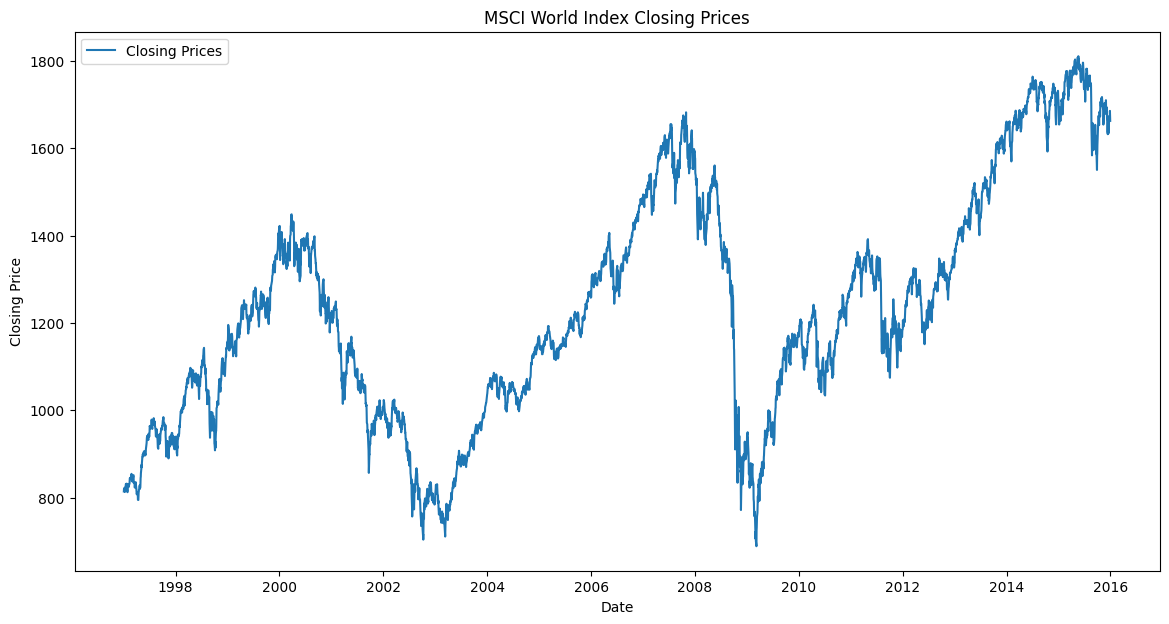

In [5]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(msci_data['Date'], msci_data['Close'], label='Closing Prices')
plt.title('MSCI World Index Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

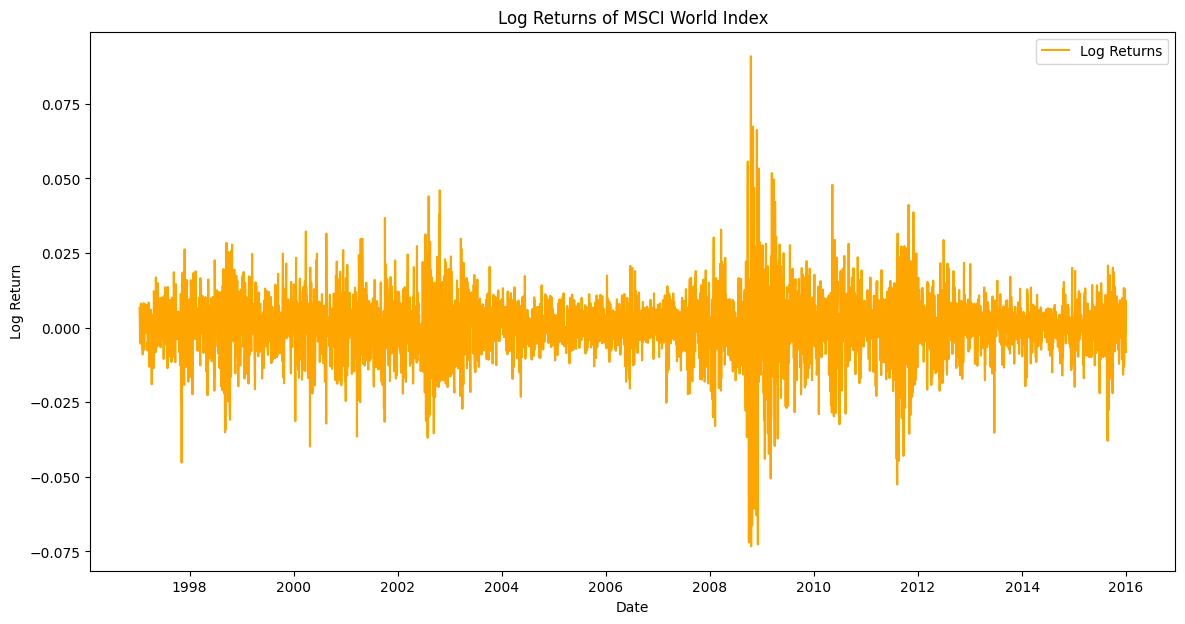

In [6]:
# Adjust 'observation_dates' to align with 'log_returns'
observation_dates_new = observation_dates[8:]  # Exclude the first date

# Now, the 'observation_dates' and 'log_returns' should have the same length
# Plot the log returns
plt.figure(figsize=(14, 7))
plt.plot(observation_dates_new, log_returns, label='Log Returns', color='orange')
plt.title('Log Returns of MSCI World Index')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()


In [7]:
# Call the function with the dates list
window_size = 260
k = 10
n_states = 2
trans_probs_list,dates_list,forecasted_means, forecasted_variances= rolling_window_estimation(
    observations, observation_dates, window_size, n_states)

{'means': array([-0.00539053,  0.00623907]), 'variances': array([3.88082549e-05, 2.11382687e-05]), 'start_prob': array([0.5, 0.5]), 'trans_prob': array([[0.99, 0.01],
       [0.01, 0.99]])}


In [8]:
print(len(forecasted_means))

4659


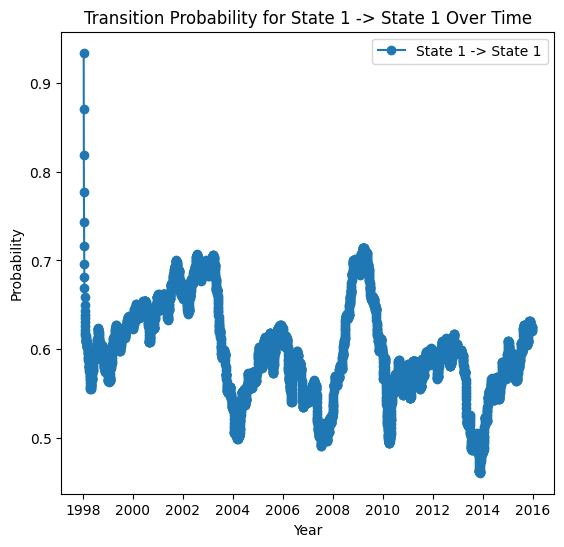

In [9]:
diag_11 = [trans_matrix[0, 0] for trans_matrix in trans_probs_list]
diag_22 = [trans_matrix[1, 1] for trans_matrix in trans_probs_list]

# Plotting the diagonal elements
plt.figure(figsize=(14, 6))

# Plot the first diagonal element over time
plt.subplot(1, 2, 1)
plt.plot(dates_list, diag_11, label='State 1 -> State 1', marker='o')
plt.xlabel('Year')
plt.ylabel('Probability')
plt.title('Transition Probability for State 1 -> State 1 Over Time')
plt.legend()


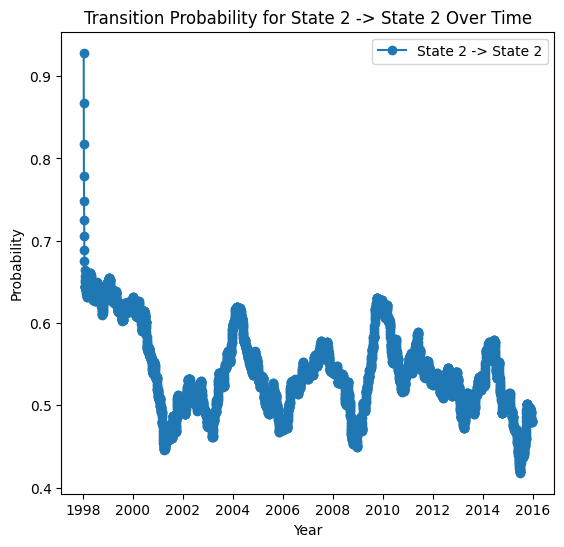

In [10]:
# Plotting the diagonal elements
plt.figure(figsize=(14, 6))

# Plot the second diagonal element over time
plt.subplot(1, 2, 1)
plt.plot(dates_list, diag_22, label='State 2 -> State 2', marker='o')
plt.xlabel('Year')
plt.ylabel('Probability')
plt.title('Transition Probability for State 2 -> State 2 Over Time')
plt.legend()

In [11]:
def optimization(h0, invested, actual_return, variance, p, com_rate, risk_para, trade_para):
    """
    Perform a single step portfolio optimization using actual return.
    """
    # Calculate the change in investment based on the new allocation p
    amount_chg = h0 * (p - invested)

    # Update invested amount by actual returns, and cash balance by the change and commission
    asset_bal = (h0 * invested + amount_chg) * (1 + actual_return)
    cash_bal = h0 * (1 - invested) - (amount_chg + abs(amount_chg) * com_rate)

    # Compute portfolio value and adjust for risk and trading aversion
    V = asset_bal + cash_bal
    risk_aversion_cost = risk_para * (asset_bal**2 * variance) / V
    trading_aversion_cost = trade_para * abs(amount_chg) / V
    V -= (risk_aversion_cost + trading_aversion_cost)

    # Update the asset and cash balances for the next time step
    invested = asset_bal / V

    return V, invested

def optimize_portfolio_allocation(h0, invested, forecasted_means, forecasted_variances, com_rate, risk_para, trade_para, K):
    # Define the objective function
    def objective_function(p_vec):
        # Evaluate portfolio value after K steps
        V = h0
        for i in range(K):
            V, _ = optimization(V, invested, forecasted_means[i], forecasted_variances[i], p_vec[i], com_rate, risk_para, trade_para)
        return -V  # Negative because we want to maximize the final value

    initial_guess = np.full(K, invested)  # Start with the current investment level
    bounds = [(0, 1) for _ in range(K)]   # p_vec should be between 0 and 1

    constraints = [
        {'type': 'ineq', 'fun': lambda x: x}, 
        {'type': 'ineq', 'fun': lambda x: 1 - x}  
    ]

    result = minimize(
        fun=objective_function,
        x0=initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 10000} 
    )

    if result.success:
        return result.x  # Optimal allocation at each time step
    else:
        raise ValueError(f"Optimization failed: {result.message}")

In [12]:
actual_log_returns=observations
# MPC without risk and trading aversion 
# Initialization of the portfolio
h0 = 100000 
com_rate = 0.001 
risk_para = 0.0  
trade_para = 0.00  
K = 10  
invested = 0.5  
portfolio_values = [h0]
trades = []
for i in range(len(forecasted_means)):
    current_means = forecasted_means[i]
    current_variances = forecasted_variances[i]
    actual_return = actual_log_returns[i]  
    # Compute an optimal sequence of trades based on forecasts
    p_vec = optimize_portfolio_allocation(
        portfolio_values[-1], invested, current_means, current_variances, com_rate, risk_para, trade_para, K
    )

    # Execute the first trade in the sequence but use the actual return to update the portfolio
    V, invested = optimization(portfolio_values[-1], invested, actual_return, current_variances[0], p_vec[0], com_rate, risk_para, trade_para)

    # Update the portfolio value based on actual return and store the trade
    portfolio_values.append(V)
    trades.append(V - portfolio_values[-2])

print("Final Portfolio Value:", portfolio_values[-1])
#print("All Trades:", trades)

Final Portfolio Value: 156621.83458878123


In [16]:
observation_dates=observation_dates[267:]

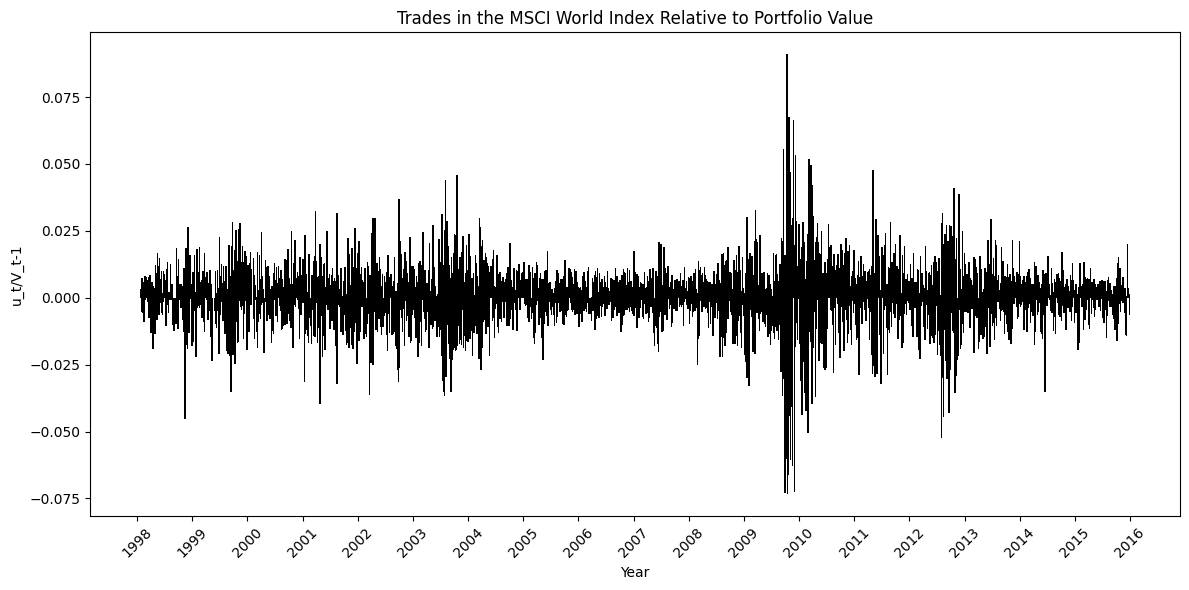

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Normalize trades by portfolio values just before the trade
normalized_trades = [trade / pv if pv != 0 else 0 for trade, pv in zip(trades, portfolio_values[:-1])]
# Plot the trades relative to portfolio value
plt.figure(figsize=(12, 6))
plt.bar(observation_dates, normalized_trades, width=10, color='black')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('u_t/V_t-1')
plt.title('Trades in the MSCI World Index Relative to Portfolio Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
import numpy as np

# Assuming daily_returns is a list of daily portfolio returns
daily_returns = [(portfolio_values[i] - portfolio_values[i - 1]) / portfolio_values[i - 1] for i in range(1, len(portfolio_values))]

# Annualized Return
annualized_return = np.prod([1 + r for r in daily_returns]) ** (252 / len(daily_returns)) - 1

# Standard Deviation
std_dev = np.std(daily_returns) * np.sqrt(252)

# Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
sharpe_ratio = (np.mean(daily_returns) / np.std(daily_returns)) * np.sqrt(252)

# Maximum Drawdown
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1.0
max_drawdown = np.min(daily_drawdown)

# Calmar Ratio
calmar_ratio = annualized_return / abs(max_drawdown)

# Annual Turnover
# Assuming trades is a list of absolute values of trades made, sum them and divide by the average portfolio value
annual_turnover = sum(trades) / np.mean(portfolio_values)

# Print the results
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Calmar Ratio: {calmar_ratio:.4f}")
print(f"Annual Turnover: {annual_turnover:.4f}")


Annualized Return: 0.0246
Standard Deviation: 0.1620
Sharpe Ratio: 0.2310
Maximum Drawdown: -0.6200
Calmar Ratio: 0.0396
Annual Turnover: 0.4481
